In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.utils.data as data
import torch.nn.functional as F
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os
import copy
import argparse
import time
import numpy as np
import pandas as pd

In [2]:
def make_dataset(dir):
    images = []
    labels = []
    dataset = pd.read_csv(os.path.join(dir, "yeast_his3.csv"))
    for _, row in dataset[["Cgroup","PhotoID", "CellID"]].iterrows():
        filename = "C_yor202w_0_0_%d_%d" % (row["PhotoID"], row["CellID"])
        image_path = os.path.join(dir, "images", filename + ".png")
        y = [0, 0, 0, 0]
        if row["Cgroup"] == "no":
            y = [1, 0, 0, 0]
        elif row["Cgroup"] == "small":
            y = [0, 1, 0, 0]
        elif row["Cgroup"] == "medium":
            y = [0, 0, 1, 0]
        elif row["Cgroup"] == "large":
            y = [0, 0, 0, 1]
        images.append(image_path)
        labels.append(np.array(y))
    return images, labels

In [3]:
# 全体を、training, valid, testに分ける。ここでは、3:1:1 に分割。
# training + valid が、機械学習の training data に相当。
datadir = "data"
X, y = make_dataset(datadir)
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size = 0.20)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size = 0.25
)

In [4]:
class DatasetFolder(data.Dataset):
    def __init__(self, X, y, loader, transform=None, target_transform=None):
        self.loader = loader
        self.samples = X
        self.targets = y
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        path = self.samples[index]
        target = self.targets[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.samples)


def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [5]:
# 画像の輝度値を補正するための関数を設定
# ResNet等のPre-trained model 学習時に利用されていた値を利用
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# 変換後の画像の幅と高さ
WIDTH = 224
HEIGHT = 224

# training (validation, testも同様）時に、画像に対して変換を加える場合は、
# ここに記述する。ResizeやFlipなど。
# 参照：https://pytorch.org/docs/stable/torchvision/transforms.html
# 変換のあと、pytorchで扱うために、Tensor型に変換してあげる必要あり。
# normalize(上記の関数)は、Tensor型に変換したあと、実施
data_transforms = {
    # training data用。必要ならaugmentation(Flipや切り出し)を行う
    # 今は、特段の加工は行わない。
    'train': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        #normalize　# 後で画像を表示するために、一旦コメントアウトしておく。
    ]),
    # validation用。通常はFlip等は行わない。
    'val': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ]),
    # test用。こちらもFlip等は実施しない
    'test': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ])
}

# クラスの変換。今回はPytorchのTensor型に変換するだけ
# 他に必要な変換がある場合には、画像同様に記載可能。
class ToTensorOfTarget(object):
    def __call__(self, target):
        return torch.from_numpy(target)

target_transforms = transforms.Compose([
        ToTensorOfTarget()
])

# 画像とクラスの読み込み用の関数を定義
image_datasets = {
    'train':DatasetFolder(X_train, y_train, pil_loader,
                              data_transforms['train'],
                              target_transforms),
    'val':DatasetFolder(X_val, y_val, pil_loader,
                             data_transforms['val'],
                             target_transforms),
    'test': DatasetFolder(X_test, y_test, pil_loader,
                             data_transforms['test'],
                             target_transforms)
}

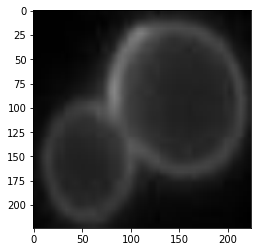

In [6]:
sample_id = 3
sample_img, _ = image_datasets['train'][sample_id]
sample_img = transforms.ToPILImage('RGB')(sample_img) # Tensor を画像に変換（もとに戻す）
plt.figure()
plt.imshow(sample_img)
plt.show()

In [7]:
data_transforms = {
    # training data用。必要ならaugmentation(Flipや切り出し)を行う
    # 今は、特段の加工は行わない。
    'train': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ]),
    # validation用。通常はFlip等は行わない。
    'val': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ]),
    # test用。こちらもFlip等は実施しない
    'test': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ])
}

In [8]:
# バッチサイズ分のデータを読み込む。
# training はデータをシャッフルし、読み込み始める画像をランダムにする。
# 他はシャッフルの必要なし。
batch_size=64
workers=0
dataloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'],
        batch_size=batch_size,
        shuffle=True,
        num_workers=workers),
    'val': torch.utils.data.DataLoader(
        image_datasets['val'],
        batch_size=batch_size,
        shuffle=False,
        num_workers=workers),
    'test': torch.utils.data.DataLoader(
        image_datasets['test'],
        batch_size=batch_size,
        shuffle=False,
        num_workers=workers)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=(1,1))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=(1,1))
        self.fc1 = nn.Linear(16 * 56 * 56, 120) # channel_num * x * y
        self.fc2 = nn.Linear(120, 4)

    def forward(self, x):
        # ** convolution layers **
        # 224 x 224 -> 112 x 112 
        x = self.pool(F.relu(self.conv1(x)))
        # 112 x 112 -> 56 x 56
        x = self.pool(F.relu(self.conv2(x)))
        # convert to 1-dim
        x = x.view(-1, 16 * 56 * 56) # channel_num * x * y
        # ** classification layers **
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
device_name = "cuda"
device = torch.device(device_name)
model = Net()
model = model.to(device_name)

In [14]:
def print_test_accuracy(model, criterion, optimizer, phase):
    running_loss = 0.0
    running_corrects = 0
    model.train(False)

    for inputs, labels in dataloaders[phase]:
        labels = labels.float()
        inputs = inputs.to(device)
        labels = labels.to(device)

        #optimizer.zero_grad()

        # 訓練のときだけ履歴を保持する
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, classnums = torch.max(labels, 1)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, classnums)

        # 統計情報
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == classnums)

    # サンプル数で割って平均を求める
    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]
    print('On Test:\tLoss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    # 途中経過でモデル保存するための初期化
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # 時間計測用
    end = time.time()

    print(model)
    print()

    for epoch in range(num_epochs):
        print('Epoch:{}/{}'.format(epoch, num_epochs - 1), end="")

        # 各エポックで訓練+バリデーションを実行
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                labels = labels.float()
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # 訓練のときだけ履歴を保持する
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, classnums = torch.max(labels, 1)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, classnums)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 統計情報
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == classnums)

            # サンプル数で割って平均を求める
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('\t{} Loss: {:.4f} Acc: {:.4f} Time: {:.4f}'.format(phase, epoch_loss, epoch_acc, time.time()-end), end="")

            # 精度が改善したらモデルを保存する
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            end = time.time()

        print()

    time_elapsed = time.time() - since
    print()
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [17]:
epochs = 20
batch_size = 64
lr = 0.01
momentum = 0.9
outdir = "."

# モデルの初期化
model = Net()
model = model.to(device)

# 損失関数、
# パラメータの最適化方法、学習率の更新方法を定義。
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

# 実際の学習を実施
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=epochs)
# テストデータでの精度を求める
print_test_accuracy(model, criterion, optimizer, 'test')

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=4, bias=True)
)

Epoch:0/19	train Loss: 1.3811 Acc: 0.2920 Time: 0.6981	val Loss: 1.3713 Acc: 0.2763 Time: 0.2095
Epoch:1/19	train Loss: 1.3686 Acc: 0.3186 Time: 0.7400	val Loss: 1.3664 Acc: 0.2763 Time: 0.2364
Epoch:2/19	train Loss: 1.3619 Acc: 0.3186 Time: 0.7659	val Loss: 1.3568 Acc: 0.2763 Time: 0.2045
Epoch:3/19	train Loss: 1.3469 Acc: 0.3186 Time: 0.6912	val Loss: 1.3254 Acc: 0.3026 Time: 0.2065
Epoch:4/19	train Loss: 1.3152 Acc: 0.3186 Time: 0.6922	val Loss: 1.2715 Acc: 0.4211 Time: 0.2074
Epoch:5/19	train Loss: 1.2463 Acc: 0.3850 Time: 0.6921	val Loss: 1.1582 Acc: 0.5132 Time: 0.2075
Epoch:6/19	train Loss: 1.0820 Acc: 0.5487 Time: 0.

In [18]:
data_transforms = {
    # 訓練データ
    # 水増し（左右反転、45度回転）を行う
    'train': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        normalize
    ]),
    # バリデーションデータ
    # 通常はFlip等は行わない。
    'val': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ]),
    # テストデータ
    # 通常はFlip等は行わない。
    'test': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ])
}

# 以下は、水増し前と同じ。
epochs = 20
batch_size = 64
lr = 0.03
momentum = 0.9
outdir = "."

model = Net()
model = model.to(device)

# 損失関数、最適化方法、学習率の更新方法を定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

# 深層学習の実行
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=epochs)
# テストデータでの精度を求める
print_test_accuracy(model, criterion, optimizer, 'test')

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=4, bias=True)
)

Epoch:0/19	train Loss: 1.3903 Acc: 0.1903 Time: 0.6931	val Loss: 1.3835 Acc: 0.2763 Time: 0.2074
Epoch:1/19	train Loss: 1.3818 Acc: 0.3186 Time: 0.7480	val Loss: 1.4008 Acc: 0.2763 Time: 0.2264
Epoch:2/19	train Loss: 1.3854 Acc: 0.3186 Time: 0.6881	val Loss: 1.3812 Acc: 0.2763 Time: 0.2094
Epoch:3/19	train Loss: 1.3746 Acc: 0.3186 Time: 0.6862	val Loss: 1.3813 Acc: 0.2763 Time: 0.2024
Epoch:4/19	train Loss: 1.3684 Acc: 0.3186 Time: 0.6832	val Loss: 1.3876 Acc: 0.2763 Time: 0.2055
Epoch:5/19	train Loss: 1.3584 Acc: 0.3717 Time: 0.6951	val Loss: 1.3979 Acc: 0.2763 Time: 0.2414
Epoch:6/19	train Loss: 1.3116 Acc: 0.3186 Time: 0.